This notebook plots the isotropic correlation function computed in the following way:
- The integral is computed with our own functions, cf overleaf
- $\dot D$ is computed with `zeus21`'s built-in function `dgrowth_dz` found in `cosmology.py`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import spherical_jn

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

import zeus21
from classy import Class
from zeus21.cosmology import growth, dgrowth_dz, Hub

In [2]:
ClassCosmo = Class()
params = {'output': 'mPk',
          'n_s': 0.965, 
          'H0': 67.4,
          'omega_b': 0.0224,
          'omega_cdm': 0.12,
          'tau_reio': 0.054,
          'sigma8': 0.811,
          'P_k_max_1/Mpc': 10
          }
ClassCosmo.set(params)
ClassCosmo.compute()

In [3]:
UserParams = zeus21.User_Parameters(precisionboost=1.2)
CosmoParams_input = zeus21.Cosmo_Parameters_Input()
ClassyCosmo = zeus21.runclass(CosmoParams_input)
CosmoParams = zeus21.Cosmo_Parameters(UserParams, CosmoParams_input, ClassyCosmo) 
CorrFClass = zeus21.Correlations(UserParams, CosmoParams, ClassyCosmo)

In [4]:
a_list = np.linspace(0.01, 1., 1000)
z_list = 1 / a_list - 1

growth_zeus = growth(CosmoParams, z_list)
dgrowth_zeus = dgrowth_dz(CosmoParams, z_list)

hubble = Hub(CosmoParams, z_list)
dgrowth_dtau = -dgrowth_zeus * hubble

# At z=0
D_dot = dgrowth_dtau[0]

/Users/yuranzhang/Desktop/untitled folder 5/marc/Zeus21/zeus21/cosmology.py:346: RuntimeWarning: invalid value encountered in divide
  return (growth(CosmoParams, z+dzlist)-growth(CosmoParams, z-dzlist))/(2.0*dzlist)


In [7]:
# Get pk from zeus21
k_zeus = CorrFClass._klistCF
pk_zeus = CorrFClass._PklinCF

# Make pk with Class
k_min = k_zeus.min()
k_max = k_zeus.max()
k_steps = k_zeus.shape[0]
# This is supposed to be an exact reconstruction of the k array used in zeus21
k_class = np.geomspace(k_min, k_max, k_steps)
pk_class = [ClassCosmo.pk(ki, z=0) for ki in k_class]

def integrand_v(r):
    return pk_class * spherical_jn(0, k_class*r)

def xi_v(r):
    integrand = integrand_v(r)
    return D_dot**2 / (2 * np.pi**2) * np.trapezoid(integrand, k_class)

r_list = CorrFClass.rlist_CF
xi_v = np.asarray([xi_v(r) for r in r_list])

Text(0.5, 1.0, 'Naive integration with $\\dot D$ computed from Zeus')

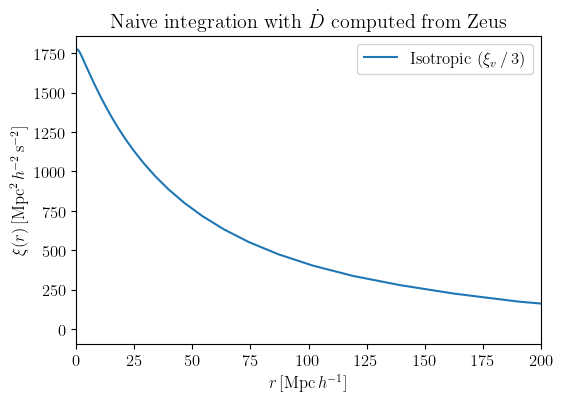

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(r_list, xi_v/3, label=r'Isotropic ($\xi_v\,/\,3$)')
plt.xlim(0, 200)
plt.xlabel(r'$r\,[\mathrm{Mpc}\,h^{-1}]$')
plt.ylabel(r'$\xi(r)\,[\mathrm{Mpc}^2\,h^{-2}\,\mathrm{s}^{-2}]$')
plt.legend()
plt.title(r'Naive integration with $\dot D$ computed from Zeus')

Tapering to zero is good, but numbers on the y-axis are quite large!